# Faceless Void
*First osint-guarded social network where platform owners have an exclusive monopoly on your personal data (ad-providers email us)*


The app is a service for creating public and private notes with face-based authentication. The server generates a face embedding from the uploaded picture and checks it against every embedding that already exist in the database. Also, you can get a list of all users sorted by their embedding’s distance to yours - closest first. 
To obtain the flag, you need to reconstruct the admin's face embedding, generate an image that matches it and read admin's private note.

## Solution

In [2]:
import io
import os
import pickle
import sys
import time
import warnings
from pathlib import Path

import faiss
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image
from torchvision import transforms

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
true_target = np.array([-0.05308838561177254, -0.030832335352897644, -0.012429395690560341, 0.09869043529033661, 0.09902559220790863, 0.09665552526712418, 0.04490641877055168, 0.05822019279003143, 0.0037725595757365227, 0.0060767862014472485, 0.015285510569810867, 0.04525212198495865, -0.0033155647106468678, 0.050329990684986115, 0.03980205953121185, 0.014112626202404499, -0.01712138205766678, 0.02415338344871998, -0.08025756478309631, -0.01516751293092966, -0.03538045287132263, 0.05690551549196243, -0.01428231131285429, 0.0016743973828852177, -0.007905100472271442, -0.058144643902778625, -0.008026964962482452, 0.04803711548447609, -0.004529684316366911, -0.04724938049912453, 0.031186703592538834, 0.02216685563325882, 0.021705109626054764, -0.03175464645028114, 0.030415883287787437, 0.06880064308643341, 0.0576784648001194, -0.01701452024281025, -0.04441274330019951, -0.017838016152381897, 0.12241334468126297, 0.005352115724235773, 0.0027453380171209574, -0.10194262862205505, 0.037844229489564896, -0.016760243102908134, 0.10557976365089417, -0.0019910642877221107, 0.009900940582156181, -0.04888731613755226, 0.034732386469841, -0.06463823467493057, 0.0584433451294899, -0.018868954852223396, -0.009984634816646576, 0.007636555470526218, -0.05207832530140877, -0.01220997329801321, 0.0516187846660614, -0.0572018064558506, -0.016838284209370613, 0.00040946932858787477, 0.00926948618143797, -0.025943247601389885, -0.06004642695188522, 0.026551637798547745, 0.0734550952911377, 0.011300042271614075, 0.0857699066400528, -0.003765505040064454, 0.019766999408602715, -0.02710920386016369, -0.03719249740242958, -0.01662486232817173, 0.05745039880275726, 0.022718355059623718, 0.06265056133270264, 0.02047983929514885, -0.02975582890212536, -0.00237763999029994, 0.08480554074048996, 0.08566391468048096, 0.0008694923017174006, 0.03017463907599449, 0.03166229650378227, 0.027995692566037178, 0.09654364734888077, -0.050889890640974045, 0.011958047747612, -0.026543380692601204, -0.03838670998811722, 0.11890766769647598, 0.0027472879737615585, 0.017647990956902504, 0.05842949077486992, 0.03253580629825592, -0.05662235617637634, -0.049982983618974686, -0.056914038956165314, 0.014478988014161587, 0.030285226181149483, 0.05350598692893982, 0.05526585876941681, -0.055379386991262436, -0.021082375198602676, 0.04220392927527428, 0.013532481156289577, -0.05576048418879509, -0.00021050430950708687, 0.04224362596869469, -0.00412773247808218, 0.04819369688630104, -0.03825971484184265, -0.012166574597358704, -0.02025763690471649, -0.02439536340534687, 0.040311284363269806, 0.019672278314828873, -0.010835439898073673, 0.020459961146116257, -0.04683287441730499, -0.033273424953222275, 0.023066187277436256, -0.06157248839735985, -0.061816003173589706, -0.0024437508545815945, 0.023016709834337234, -0.031515803188085556, 0.004810449667274952, -0.05782458931207657, 0.11365649849176407, -0.030894853174686432, -0.027022741734981537, -0.03320822864770889, 0.012772378511726856, 0.046176403760910034, 0.02397456206381321, 0.01035608071833849, 0.03185787424445152, 0.003366099903360009, -0.001142553286626935, 0.038594599813222885, 0.029985982924699783, 0.059111203998327255, 0.05811518430709839, 0.044642943888902664, -0.0872562974691391, 0.004869728349149227, 0.04420173168182373, -0.058026768267154694, 0.010522921569645405, -0.07584109902381897, -0.04460499435663223, -0.023640446364879608, -0.00041568686719983816, -0.01876528188586235, 0.020029915496706963, 0.001605388824827969, -0.056907668709754944, -0.0014736506855115294, -0.0631122887134552, 0.023330049589276314, 0.022234275937080383, -0.00949565228074789, -0.028285115957260132, -0.045578502118587494, -0.0834340900182724, -0.01740504615008831, 0.03310227021574974, -0.008736155927181244, -0.04242836683988571, 0.008467860519886017, -0.029759962111711502, 0.039271093904972076, 0.0504743866622448, 0.0817062184214592, 0.04253789037466049, 0.00923588965088129, -0.023860447108745575, 0.012637509033083916, -0.07378923892974854, 0.0190601609647274, -0.014621672220528126, -0.004422917030751705, -0.008989289402961731, -0.022565802559256554, 0.038980837911367416, -0.008469194173812866, 0.039771489799022675, -0.020355671644210815, 0.012275030836462975, -0.0053380876779556274, 0.0338178314268589, 0.04747629538178444, 0.0677252858877182, 0.027958858758211136, -0.006737764924764633, 0.008283753879368305, -0.013260135427117348, 0.036462608724832535, -0.054669372737407684, -0.016920417547225952, 0.07864419370889664, -0.01746244542300701, 0.0017469972372055054, -0.014535232447087765, 0.017182499170303345, 0.06961482763290405, 0.044394634664058685, 0.010107009671628475, -0.04919407144188881, -0.020761338993906975, -0.05797455832362175, 0.01677997037768364, -0.051716700196266174, 0.0762048214673996, -0.08496680855751038, 0.01608232967555523, -0.06683078408241272, -0.051850512623786926, 0.0339445136487484, 0.04820132255554199, -0.028126489371061325, 0.08500577509403229, -0.010123328305780888, 0.0332338884472847, -0.016965363174676895, -0.04551168158650398, 0.007134624291211367, 0.03291318193078041, -0.0367867536842823, -0.034262388944625854, 0.02486090175807476, -0.03279029577970505, -0.04090098664164543, 0.005234844982624054, -0.012950957752764225, 0.0205796267837286, -0.03321436047554016, 0.05950513109564781, -0.051784154027700424, 0.015274114906787872, 0.0400811992585659, -0.03050141967833042, 0.03841417655348778, -0.0701029971241951, 0.008522612042725086, -0.07249242067337036, -0.002701765624806285, 0.04942554980516434, 0.006458176299929619, -0.008223048411309719, -0.09336291998624802, 0.013598820194602013, 0.03810996562242508, -0.02430175617337227, 0.008948896080255508, -0.0019723467994481325, 0.005450090859085321, -0.0009789748582988977, -0.0004728286003228277, 0.05309626832604408, 0.06683749705553055, -0.10014103353023529, -0.00524058798328042, -0.02520378679037094, 0.015124847181141376, 0.061485655605793, 0.07204269617795944, -0.040555018931627274, -0.0719774141907692, -0.0660552978515625, -0.035449933260679245, -0.037232160568237305, 0.008521772921085358, -0.08747298270463943, -0.07136694341897964, -0.05253677815198898, -0.020737173035740852, 0.04717518389225006, 0.026142604649066925, 0.05585552006959915, -0.03603799641132355, -0.009790751151740551, -0.014847829937934875, 0.042887069284915924, -0.006381042767316103, 0.042331717908382416, 0.00932009331882, -0.046596281230449677, 0.0009643058874644339, 0.010278217494487762, 0.014537598937749863, -0.02892124094069004, -0.040984828025102615, 0.03468560054898262, 0.07270394265651703, 0.003757850266993046, -0.04223722219467163, -0.05168910324573517, 0.03859710320830345, 0.031759921461343765, 0.02851990982890129, 0.012229707092046738, 0.008275632746517658, -0.02826707251369953, -0.055142842233181, -0.029317054897546768, -0.04505109786987305, -0.0016611118335276842, 0.06489008665084839, 0.05046304687857628, 0.004391585011035204, 0.057191431522369385, -0.002743638353422284, 0.03962789103388786, 0.04029146209359169, 0.08211032301187515, 0.003990239463746548, -0.004486322868615389, 0.060844894498586655, -0.0382881723344326, 0.07561572641134262, -0.0033028547186404467, 0.12641102075576782, -0.04714716970920563, 0.04668513312935829, 0.010860169306397438, 0.08364558964967728, -0.0014752313727512956, -0.0025331571232527494, 0.010860100388526917, 0.05501307174563408, -0.0471484549343586, -0.04987439513206482, 0.005827304441481829, 0.06754884123802185, 0.0039751967415213585, -0.0012146274093538523, -0.0030293914023786783, 0.0654488131403923, -0.03801385313272476, -0.035037748515605927, -0.0027924145106226206, 0.060592737048864365, -0.028168827295303345, -0.03251848369836807, 0.08048777282238007, -0.06112735718488693, -0.059595607221126556, 0.06293855607509613, -0.013024579733610153, -0.058112096041440964, 0.011820295825600624, 0.047668080776929855, 0.01629340834915638, -0.01087851170450449, 0.011931772343814373, 0.03321816772222519, 0.022402184084057808, 0.008887545205652714, 0.04897912219166756, -0.008642834611237049, 0.03031621314585209, -0.030194560065865517, 0.05073785036802292, -0.05139939486980438, 0.03846320882439613, 0.015359506942331791, 0.0044016712345182896, 0.022864563390612602, -0.07180003821849823, 0.017137380316853523, -0.02314157225191593, -0.04644932597875595, 0.023539936169981956, -0.028570597991347313, 0.017871839925646782, 0.03457138314843178, -0.019806480035185814, -0.05021371319890022, 0.004646834917366505, -0.004310531076043844, -0.02431788295507431, -0.035324592143297195, 0.022808099165558815, -0.025141289457678795, -0.01387588307261467, 0.013438896276056767, -0.061648495495319366, -0.029365291818976402, -0.007877202704548836, -0.03581634908914566, -0.10220228135585785, -0.0061681861989200115, 0.04483960568904877, -0.007289358414709568, -0.04184890538454056, 0.09920898079872131, 0.09506752341985703, -0.09888393431901932, 0.0322081483900547, -0.02993123047053814, -0.021627753973007202, 0.04462626203894615, 0.04828944802284241, 0.03267150744795799, -0.02842363901436329, 0.11038479954004288, -0.031142208725214005, 0.026898544281721115, -0.08071661740541458, 0.11112429201602936, -0.04948163777589798, -0.024510525166988373, 0.021531417965888977, -0.010800540447235107, -0.03111139126121998, 0.006724637467414141, -0.035961221903562546, 0.027429526671767235, -0.05173265561461449, -0.02843707986176014, 0.01735214702785015, -0.031544823199510574, -0.03848928585648537, -0.038383569568395615, 0.05497726425528526, -0.05604027956724167, -0.06370913982391357, -0.014063665643334389, 0.01706146076321602, -0.0011999844573438168, -0.003190485294908285, -0.006675481330603361, -0.08000937849283218, -0.02975352667272091, 0.020137205719947815, -0.03602055832743645, -0.10043567419052124, -0.059332475066185, -0.10558371245861053, -0.023019645363092422, 0.017190003767609596, -0.04074482247233391, 0.009164388291537762, -0.010841970331966877, 0.04295433312654495, -0.01041897851973772, 0.01604527235031128, 0.028254682198166847, -0.08091838657855988, -0.013624725863337517, 0.01651967689394951, -0.0011913737980648875, 0.010179176926612854, 0.012962034903466702, -0.02109270915389061, -0.028399411588907242, 0.016554979607462883, -0.036983177065849304, 0.016808168962597847, -0.020683495327830315, -0.009979820810258389, -0.018619567155838013, -0.017899656668305397, 0.0017339731566607952, -0.037429407238960266, -0.05692552402615547, -0.02112591452896595, -0.04529289901256561, -0.028846528381109238, -0.048702389001846313, 0.03432552516460419, 0.004906116984784603, 0.018052389845252037, 0.018069105222821236, 0.046796172857284546, 0.060015443712472916, 0.019412750378251076, 0.05156485736370087, 0.01977270096540451, -0.12441077083349228, -0.09646601229906082, -0.026355016976594925, -0.03905617818236351, 0.00034370069624856114, -0.09856606274843216, 0.007165271323174238, 0.05354612320661545, -0.03249907121062279, -0.030944375321269035, 0.01636834256350994, 0.012376313097774982, -0.04757332056760788, -0.10397475212812424, 0.043676652014255524, -0.03060062974691391, -0.041507214307785034, 0.08027246594429016, 0.024535752832889557, -0.02540571615099907, 0.0485733225941658, -0.057250309735536575, -0.01911490596830845, -0.0620734803378582, 0.04676061123609543, 0.016686679795384407, 0.09981691837310791, 0.02268502674996853, -0.03535512834787369, 0.06000541150569916])
target_id = "ae2214a1-949e-40da-b14d-02df5eba363b"
SERVER_IP = "http://10.132.0.30:6464/api"
IMAGE_DIR = "celeba/celeba/img_align_celeba/"
EMBEDDING_DIM = 512
SIMILARITY_THRESHOLD = 0.35

REPO_DIR = Path("stylegan2-ada-pytorch") 
if str(REPO_DIR) not in sys.path: 
    sys.path.insert(0, str(REPO_DIR))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder = InceptionResnetV1(pretrained="vggface2").to(device).eval()

def get_face_embedding(image: Image.Image) -> np.ndarray:
    preprocess = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],
                             std=[0.5,0.5,0.5]),
    ])

    img_t = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = embedder(img_t)                   
        emb = F.normalize(emb, p=2, dim=1)     
    return emb.squeeze(0).cpu().numpy()    


def auth(image_path):
    url = f"{SERVER_IP}/auth"
    
    with open(image_path, "rb") as file:
        files = {"file": (image_path, file, "image/jpeg")}
        response = requests.post(url, files=files)
        response = response.json()
        token, uuid = response["access_token"], response["user_id"]
        return token, uuid
    
def get_users(token):
    url = f"{SERVER_IP}/users"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    return response.json()['users']

def get_private_notes(token):
    url = f"{SERVER_IP}/notes"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    return response.json()['private_notes']
    
class Store(dict):
    def id_to_vec(self, id: str):
        return self[id][1]

store = Store()

Loop through image files in the specified directory, compute each image’s face embedding, authenticate the anchor user via the `/auth` API endpoint, and store the resulting user ID with its file path and embedding:

In [5]:
m = 0
for filename in os.listdir(IMAGE_DIR):
    if m == EMBEDDING_DIM + 1:
        break
    image_path = os.path.join(IMAGE_DIR, filename)
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        with open(image_path, "rb") as file:
            contents = file.read()
            image = Image.open(io.BytesIO(contents)).convert("RGB")
            embedding = get_face_embedding(image)
        try:
            token, user_id = auth(image_path)
        except Exception as e:
            print(e)
        store[user_id] = (image_path, embedding)
        m += 1

Compute approximate distances from each registered user’s embedding to the target by querying their neighbor rankings, then set up and solve a linear multilateration system (using least squares) to get an initial estimate of the target’s embedding. Next, refine that estimate via gradient descent minimizing the mean squared error between predicted and approximate distances. Finally calculcate L2 error against the true embedding (for the evaluation):

In [6]:
rhos = []
store_keys = list(store.keys())
m = len(store_keys)

for aid in store_keys:
    token, uuid = auth(store[aid][0])
    nbrs = get_users(token) 

    pos = nbrs.index(target_id)
    v_aid = store.id_to_vec(aid)

    if pos == 0:
        v_next = store.id_to_vec(nbrs[1])
        rho_i = np.linalg.norm(v_aid - v_next)
    elif pos == m:
        v_prev = store.id_to_vec(nbrs[-2])
        rho_i = np.linalg.norm(v_aid - v_prev)
    else:
        v_prev = store.id_to_vec(nbrs[pos-1])
        v_next = store.id_to_vec(nbrs[pos+1])
        d_prev = np.linalg.norm(v_aid - v_prev)
        d_next = np.linalg.norm(v_aid - v_next)
        rho_i = 0.5 * (d_prev + d_next)

    rhos.append(rho_i)


dim = store.id_to_vec(store_keys[0]).shape[0]
R1 = store.id_to_vec(store_keys[0]) 
rho1 = rhos[0]

A = np.zeros((m-1, dim), dtype=np.float32)
b = np.zeros(m-1, dtype=np.float32)

for i in range(1, m):
    Ri = store.id_to_vec(store_keys[i])  
    rhoi = rhos[i]                        

    A[i-1, :] = 2.0 * (Ri - R1)
    b[i-1] = (rho1**2 - rhoi**2) + (Ri.dot(Ri) - R1.dot(R1))

x_est, *_ = np.linalg.lstsq(A, b, rcond=None)
x_est = x_est / np.linalg.norm(x_est)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.tensor(x_est, dtype=torch.float32, device=device, requires_grad=True)

vecs = np.stack([store.id_to_vec(aid) for aid in store_keys], axis=0) 
A_t = torch.tensor(vecs, dtype=torch.float32, device=device)         
rhos_torch = torch.tensor(np.array(rhos, dtype=np.float32), device=device) 

opt = optim.Adam([x], lr=1e-2)

for step in range(500):
    opt.zero_grad()
    d = torch.norm(x.unsqueeze(0) - A_t, dim=1)
    loss = torch.mean((d - rhos_torch) ** 2)
    loss.backward()
    opt.step()

x_final = x.detach().cpu().numpy() 
x_final = x_final / np.linalg.norm(x_final)

print("L2 error:", np.linalg.norm(x_final - true_target))

L2 error: 0.12680246820751356


In [12]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch # with some monkey patching for plugins
!wget -O stylegan2-ada-pytorch/ffhq.pkl -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Now we can use [StyleGAN2‐ADA](https://github.com/NVlabs/stylegan2-ada-pytorch) to optimize a latent vector so that the generated face’s embedding matches the recovered target embedding, then saves the resulting image.

In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)
def load_stylegan(ckpt: str, device):
    with open(ckpt, "rb") as f:
        G = pickle.load(f)["G_ema"].to(device).eval().requires_grad_(False)
    return G

def to_facenet_range(img: torch.Tensor):
    return img * 2.0 - 1.0

def optimise_latent(target_emb: torch.Tensor, G, embedder,
                    steps: int, lr: float):
    device = target_emb.device
    w_dim, n_ws = G.w_dim, G.num_ws
    w = (G.mapping.w_avg + torch.randn(1, n_ws, w_dim, device=device) * 0.05)
    w.requires_grad_(True)

    opt = torch.optim.Adam([w], lr=lr)

    for step in range(steps):
        img = G.synthesis(w, noise_mode="const").clamp(-1, 1)
        img_interpolated = torch.nn.functional.interpolate(
            img, size=(160, 160), mode='bilinear', 
            align_corners=False, antialias=True
        )
        emb_pred = embedder(img_interpolated)
        loss = torch.nn.functional.pairwise_distance(emb_pred,target_emb).square().mean()

        opt.zero_grad(); loss.backward(); opt.step()
        if step % 100 == 0 or step == steps - 1:
            print(f"{step:04d}/{steps}  loss={loss.item():.10f}")
    return img.detach(), emb_pred

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedder = InceptionResnetV1(pretrained="vggface2").to(device).eval()
G = load_stylegan("stylegan2-ada-pytorch/ffhq.pkl", device)

result, emb = optimise_latent(torch.tensor(x_final).cuda(), G, embedder, steps=1000, lr=0.05)

img = (result.clamp(-1, 1)[0] + 1) * 127.5
img = img.permute(1, 2, 0).cpu().numpy()
img = np.rint(img).clip(0, 255).astype(np.uint8)
Image.fromarray(img, "RGB").save("solve.jpg")

0000/1000  loss=2.1330547333
0100/1000  loss=0.0181913506
0200/1000  loss=0.0157354586
0300/1000  loss=0.0159125775
0400/1000  loss=0.0157071352
0500/1000  loss=0.0158119425
0600/1000  loss=0.0157245900
0700/1000  loss=0.0156946331
0800/1000  loss=0.0156963505
0900/1000  loss=0.0156917386
0999/1000  loss=0.0156988893


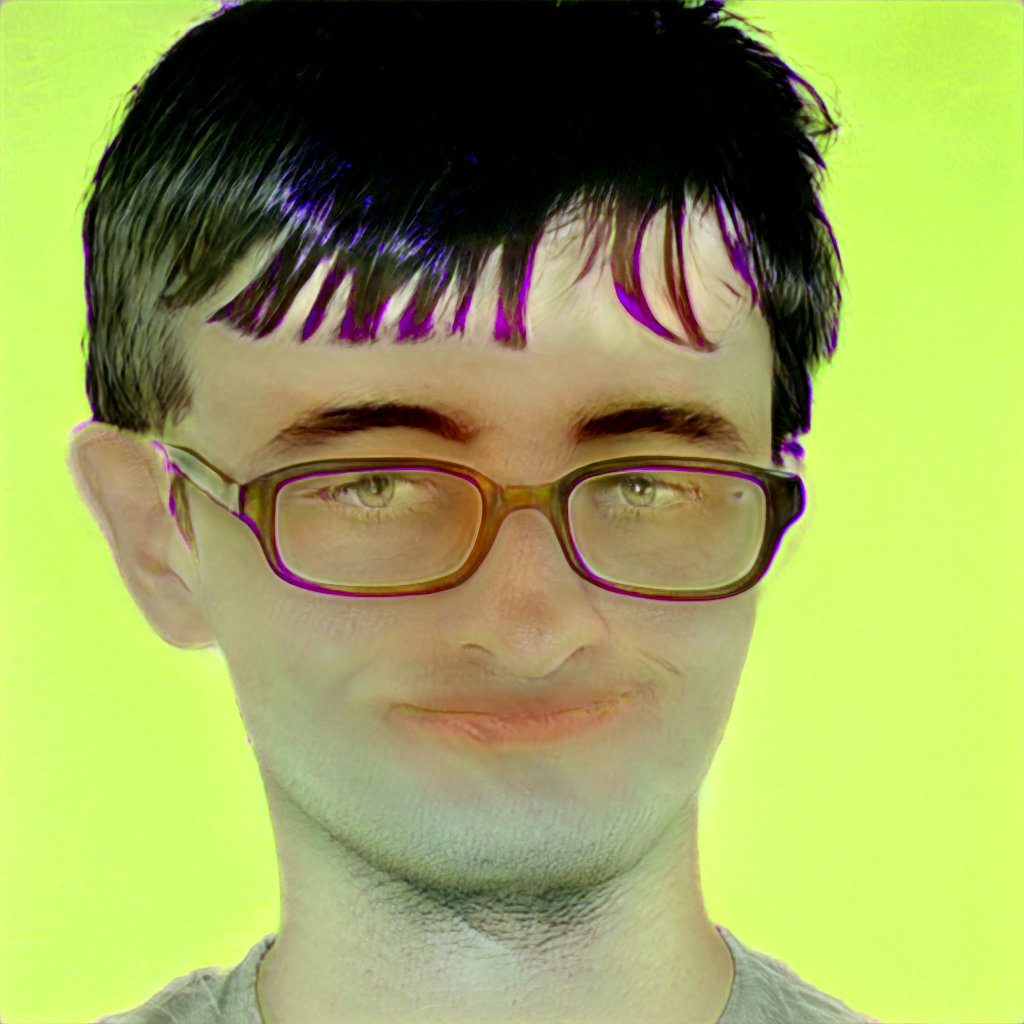

In [10]:
display(Image.fromarray(img, "RGB"))

In [11]:
token, user_id = auth("solve.jpg")
get_private_notes(token)

['From a place beyond time, and time beyond counting. Here is your flag: SAS{br0_y0u_just_st0l3_my_f4c3_but_n0t_my_s0ul}']